In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
from PIL import Image
import librosa
import random
import soundfile as sf
import noisereduce as nr
from scipy.signal import butter, sosfilt
from tqdm import tqdm
import tensorflow_hub as hub
import tensorflow as tf

import torch
import torch.nn as nn
import glob

import os 
import io
from pathlib import Path

from ast import literal_eval
import logging



In [3]:
class Config:
    train_dir = "C:\\Users\\Vineet\\Desktop\\Case Study Data Mining\\birdclef-2025\\train_audio"
    train_bird_dir = "C:\\Users\\Vineet\\Desktop\\Case Study Data Mining\\birdclef-2025\\train_audio_bird"
    bird_dir  = "C:\\Users\\Vineet\\Desktop\\Case Study Data Mining\\birdclef-2025\\train_audio_bird"
    seed = 42
    train_csv = "C:\\Users\\Vineet\\Desktop\\Case Study Data Mining\\birdclef-2025\\train.csv"
    sample_csv = "C:\\Users\\Vineet\\Desktop\\Case Study Data Mining\\birdclef-2025\\sample_submission.csv"
    test_soundscapes = "C:\\Users\\Vineet\\Desktop\\Case Study Data Mining\\birdclef-2025\\test_soundscapes"
    taxonomy_path = "C:\\Users\\Vineet\\Desktop\\Case Study Data Mining\\birdclef-2025\\taxonomy.csv"
    processed_audio_dir = "C:\\Users\\Vineet\\Desktop\\Case Study Data Mining\\birdclef-2025\\processed_audio"
    birdnet_threshold = 0.3 # Threshold for BirdNet predictions
    sr = int(32e3)  # Sample rate
    num_classes = 206 # Number of classes
    n_fft = 1024 # fft points (samples)
    hop_length = 500 # hop length (samples)
    n_mels = 128 # number of mel bands
    fmin = 50 # minimum frequency (Hz)
    fmax = 16000 # maximum frequency (Hz)
    power = 2 # power for mel-spectrogram
    rms_thresh = 0.01  # below this = too quiet
    silent_pct = 0.5  
    
    sample_rate = 32000
    sr_target = 16000
    lowcut = 1000
    highcut = 7900
    order = 4
    target_duration_sec = 5  # target audio length in seconds
    target_length = sr_target * target_duration_sec

    

In [17]:
Config.train_bird_dir

'C:\\Users\\Vineet\\Desktop\\Case Study Data Mining\\birdclef-2025\\train_audio_bird'

In [5]:
def set_seed(seed: int = Config.seed) -> None:
    """
    Set the random seed for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    print(f"Random seed set to {seed}.")

set_seed()

Random seed set to 42.


In [6]:
data_df = pd.read_csv(Config.train_csv)

for col in ('secondary_labels', 'type'):   
    data_df[col] = data_df[col].apply (lambda x: '###'.join(literal_eval(x)))
                                      

data_df['filename'] = data_df['filename'].apply(lambda x: Config.train_dir + "/" + x)

data_df.sample(10)

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
27685,yeofly1,,call,C:\Users\Vineet\Desktop\Case Study Data Mining...,XC,4.0,https://xeno-canto.org/250351,-4.4010,-79.8540,Tolmomyias sulphurescens,Yellow-olive Flycatcher,Niels Krabbe,cc-by-sa 4.0
25019,whbman1,,mechanical sounds,C:\Users\Vineet\Desktop\Case Study Data Mining...,XC,5.0,https://xeno-canto.org/268585,-19.7323,-41.8141,Manacus manacus,White-bearded Manakin,Fabrice Schmitt,cc-by-nc-sa 4.0
96,21211,,,C:\Users\Vineet\Desktop\Case Study Data Mining...,XC,3.0,https://xeno-canto.org/913998,4.0946,-52.6862,Allobates femoralis,Spotted-thighed Poison Frog,Delaitre guillaume,cc-by-nc-sa 4.0
5771,bugtan,,flight call,C:\Users\Vineet\Desktop\Case Study Data Mining...,XC,5.0,https://xeno-canto.org/480423,-0.4383,-76.2791,Thraupis episcopus,Blue-gray Tanager,Jerome Fischer,cc-by-nc-sa 4.0
21879,strher,greani1###grekis,flight call,C:\Users\Vineet\Desktop\Case Study Data Mining...,XC,3.5,https://xeno-canto.org/287867,-22.4508,-42.7735,Butorides striata,Striated Heron,Jerome Fischer,cc-by-nc-sa 4.0
550,517119,,,C:\Users\Vineet\Desktop\Case Study Data Mining...,iNat,0.0,https://static.inaturalist.org/sounds/627646.mp3,13.9296,-88.1021,Rhinella horribilis,Giant Toad,Carlos Funes,cc-by 4.0
1512,anhing,,,C:\Users\Vineet\Desktop\Case Study Data Mining...,iNat,0.0,https://static.inaturalist.org/sounds/198504.wav,24.7054,-81.3802,Anhinga anhinga,Anhinga,Nick Tepper,cc-by-nc 4.0
18405,smbani,,call,C:\Users\Vineet\Desktop\Case Study Data Mining...,XC,3.0,https://xeno-canto.org/461360,-12.7210,-71.3649,Crotophaga ani,Smooth-billed Ani,Blair Jollands,cc-by-nc-sa 4.0
19569,socfly1,,,C:\Users\Vineet\Desktop\Case Study Data Mining...,iNat,0.0,https://static.inaturalist.org/sounds/360705.wav,20.5138,-97.4619,Myiozetetes similis,Social Flycatcher,pozaricaalnatural,cc-by-nc 4.0
11127,grekis,,,C:\Users\Vineet\Desktop\Case Study Data Mining...,iNat,0.0,https://static.inaturalist.org/sounds/356146.wav,27.5389,-99.4917,Pitangus sulphuratus,Great Kiskadee,Diane Bricmont,cc-by-nc 4.0


In [7]:
data_df.isnull().sum()

primary_label         0
secondary_labels      0
type                  0
filename              0
collection            0
rating                0
url                   0
latitude            809
longitude           809
scientific_name       0
common_name           0
author                0
license               0
dtype: int64

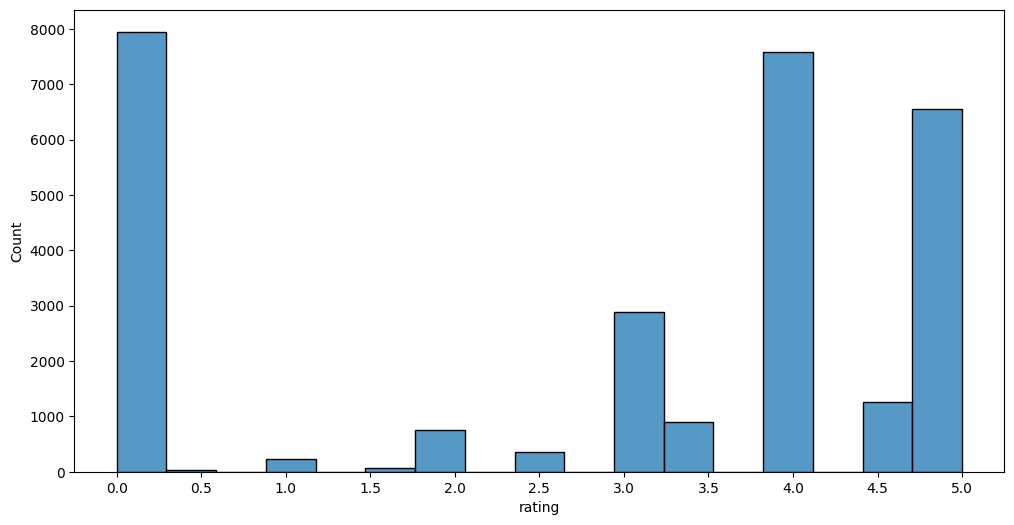

In [8]:
plt.figure(figsize=(12, 6))
sns.histplot(data_df, x='rating')
plt.xticks(np.arange(0, 5.5, 0.5))
plt.show()

C:\Users\Vineet\AppData\Local\Temp\ipykernel_34552\3426734436.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=primary_label_counts.values, y=primary_label_counts.index, palette="viridis")


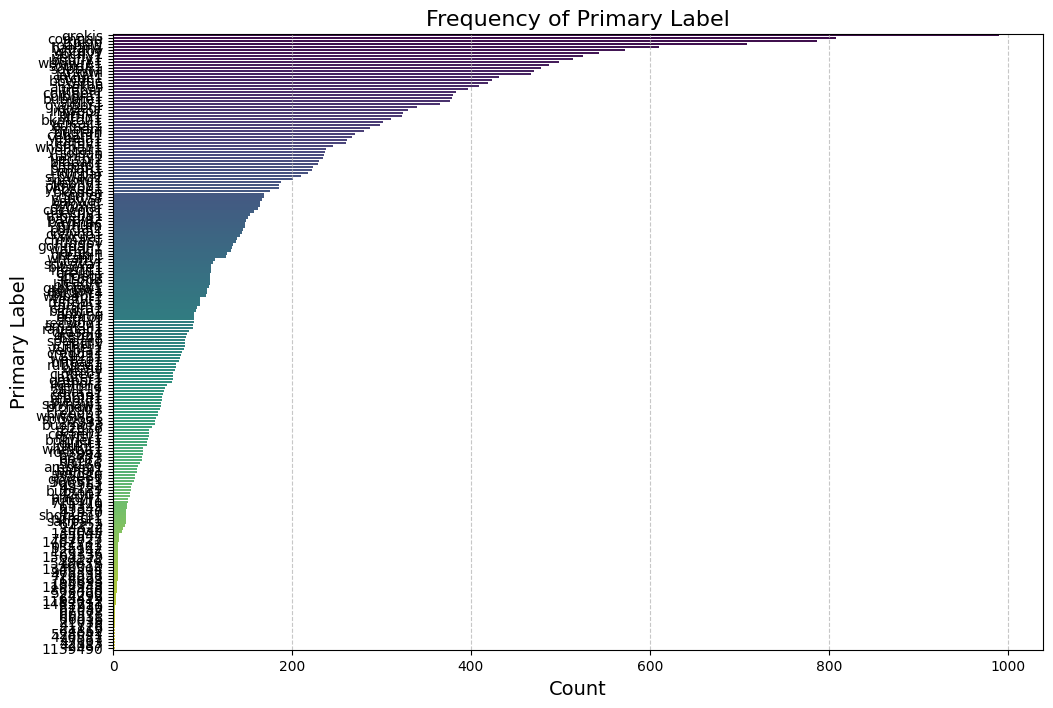

In [9]:
primary_label_counts = data_df['primary_label'].explode().value_counts()

# Plot the frequency of primary labels
plt.figure(figsize=(12, 8))
sns.barplot(x=primary_label_counts.values, y=primary_label_counts.index, palette="viridis")
plt.title('Frequency of Primary Label', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Primary Label', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

C:\Users\Vineet\AppData\Local\Temp\ipykernel_8328\2760401104.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_labels.values, y=top_labels.index, palette="viridis")


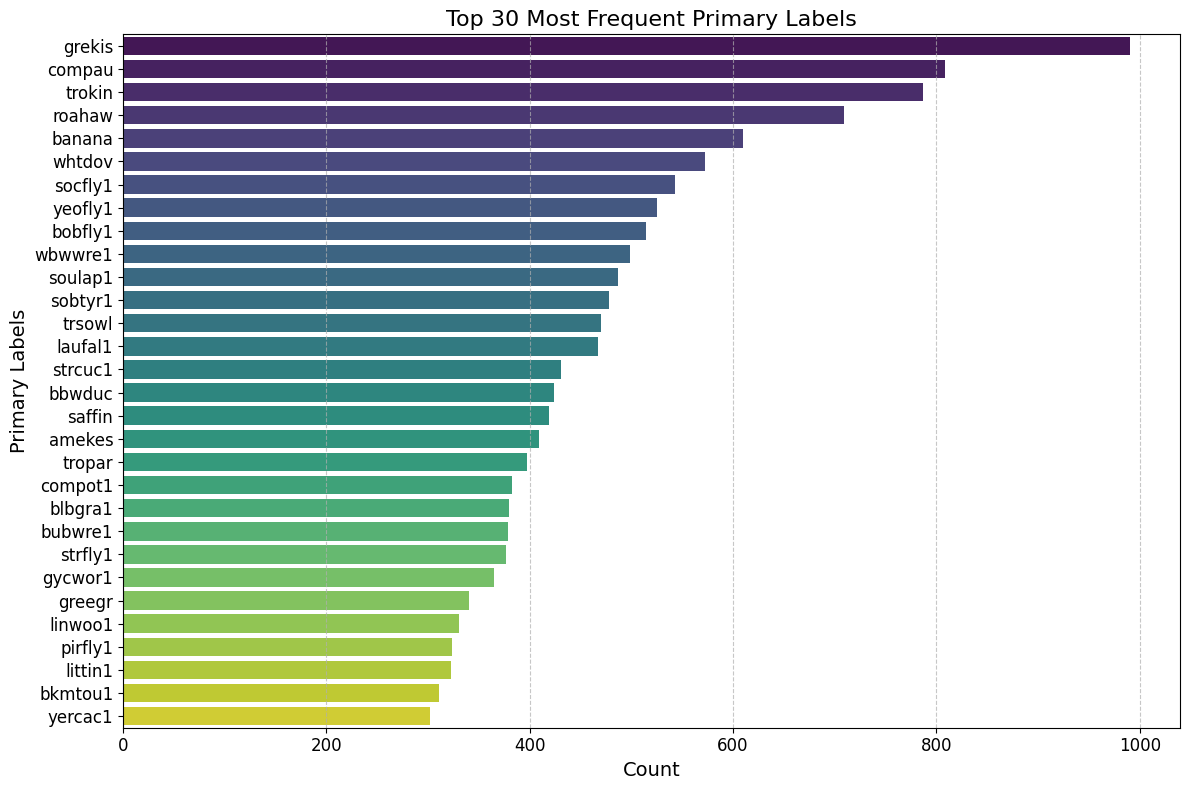

In [8]:
# Count the frequency of each unique value in the 'primary_labels' column
primary_label_counts = data_df['primary_label'].explode().value_counts()

# Select the top 20 most frequent labels for better readability
top_labels = primary_label_counts.head(30)

# Plot the frequency of the top primary labels
plt.figure(figsize=(12, 8))
sns.barplot(x=top_labels.values, y=top_labels.index, palette="viridis")
plt.title('Top 30 Most Frequent Primary Labels', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Primary Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
# # Count the frequency of each unique value in the 'primary_labels' column
# primary_label_counts = data_df['primary_label'].explode().value_counts()

# # Define a threshold for low-frequency labels
# threshold = 80  # Labels with frequency <= 10 will be grouped into "Other"

# # Separate labels into "Other" and frequent labels
# frequent_labels = primary_label_counts[primary_label_counts > threshold]
# other_count = primary_label_counts[primary_label_counts <= threshold].sum()

# # Add the "Other" category using pd.concat
# aggregated_labels = pd.concat([frequent_labels, pd.Series({'Other': other_count})])

# # Plot the aggregated labels
# plt.figure(figsize=(12, 8))
# sns.barplot(x=aggregated_labels.values, y=aggregated_labels.index, palette="viridis")
# plt.title('Frequency of Primary Labels (Aggregated)', fontsize=16)
# plt.xlabel('Count', fontsize=14)
# plt.ylabel('Primary Labels', fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

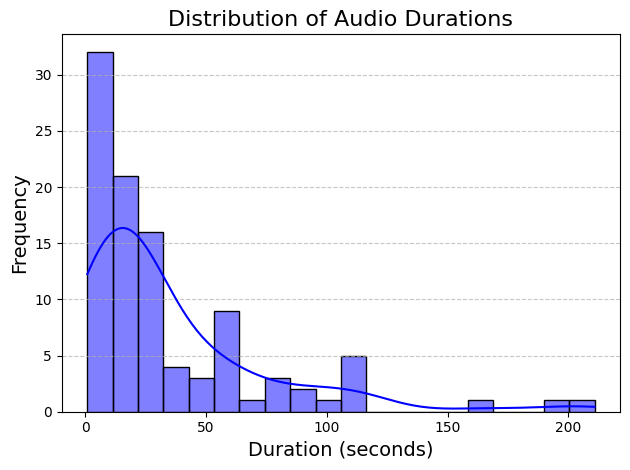

Processed 100 audio files.


In [10]:
# Sample 100 rows from the DataFrame
sampled_data = data_df.sample(n=100, random_state=Config.seed)

# Calculate durations of audio files
durations = []
for filename in sampled_data['filename']:
    try:
        signal, sr = librosa.load(filename, sr=Config.sr)
        durations.append(librosa.get_duration(y=signal, sr=sr))
    except Exception as e:
        print(f"Error processing {filename}: {e}")



# Plot the distribution of audio durations
sns.histplot(durations, bins=20, kde=True, color='blue')
plt.title('Distribution of Audio Durations', fontsize=16)
plt.xlabel('Duration (seconds)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"Processed {len(durations)} audio files.")

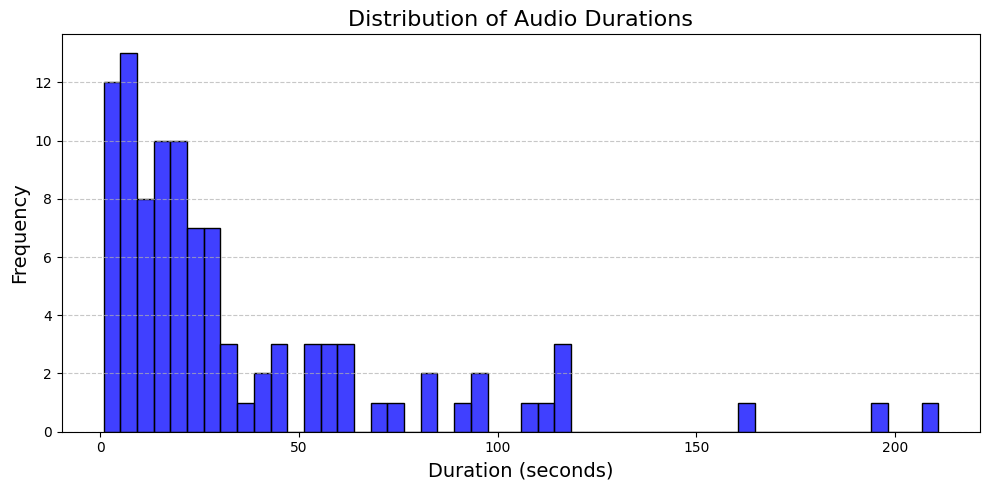

count    100.000000
mean      35.327839
std       40.285340
min        0.878750
25%        9.266945
50%       20.472750
75%       44.648250
max      210.901344
Name: duration, dtype: float64


In [11]:
# Sample 100 rows from the DataFrame
sampled_data = data_df.sample(n=100, random_state=Config.seed)

# Calculate durations of audio files
durations = [
    librosa.get_duration(y=librosa.load(row['filename'], sr=Config.sr)[0], sr=Config.sr)
    for _, row in sampled_data.iterrows()
]

# Add the durations as a new column to the sampled DataFrame
sampled_data['duration'] = durations

# Plot the distribution of audio durations
plt.figure(figsize=(10, 5))
sns.histplot(sampled_data, x='duration', bins=50, color='blue')
plt.title('Distribution of Audio Durations', fontsize=16)
plt.xlabel('Duration (seconds)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display statistics of the durations
print(sampled_data['duration'].describe())

In [12]:
data_df.shape

(28564, 13)

In [13]:
# # Function to plot the Mel-spectrogram for a single audio file
# def plot_mel_spectrogram(filename):
#     try:
#         # Load the audio file
#         signal, sr = librosa.load(filename, sr=Config.sr)
        
#         # Compute the Mel-spectrogram
#         mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128, fmax=8000)
        
#         # Convert to decibels for better visualization
#         mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
#         # Plot the Mel-spectrogram
#         plt.figure(figsize=(10, 6))
#         librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='viridis')
#         plt.colorbar(format='%+2.0f dB')
#         plt.title('Mel-Spectrogram', fontsize=16)
#         plt.xlabel('Time (s)', fontsize=14)
#         plt.ylabel('Frequency (Hz)', fontsize=14)
#         plt.tight_layout()
#         plt.show()
#     except Exception as e:
#         print(f"Error processing {filename}: {e}")

# # Example: Plot the Mel-spectrogram for the first audio file in the DataFrame
# example_filename = data_df['filename'].iloc[0]  # Replace with any valid filename
# plot_mel_spectrogram(example_filename)

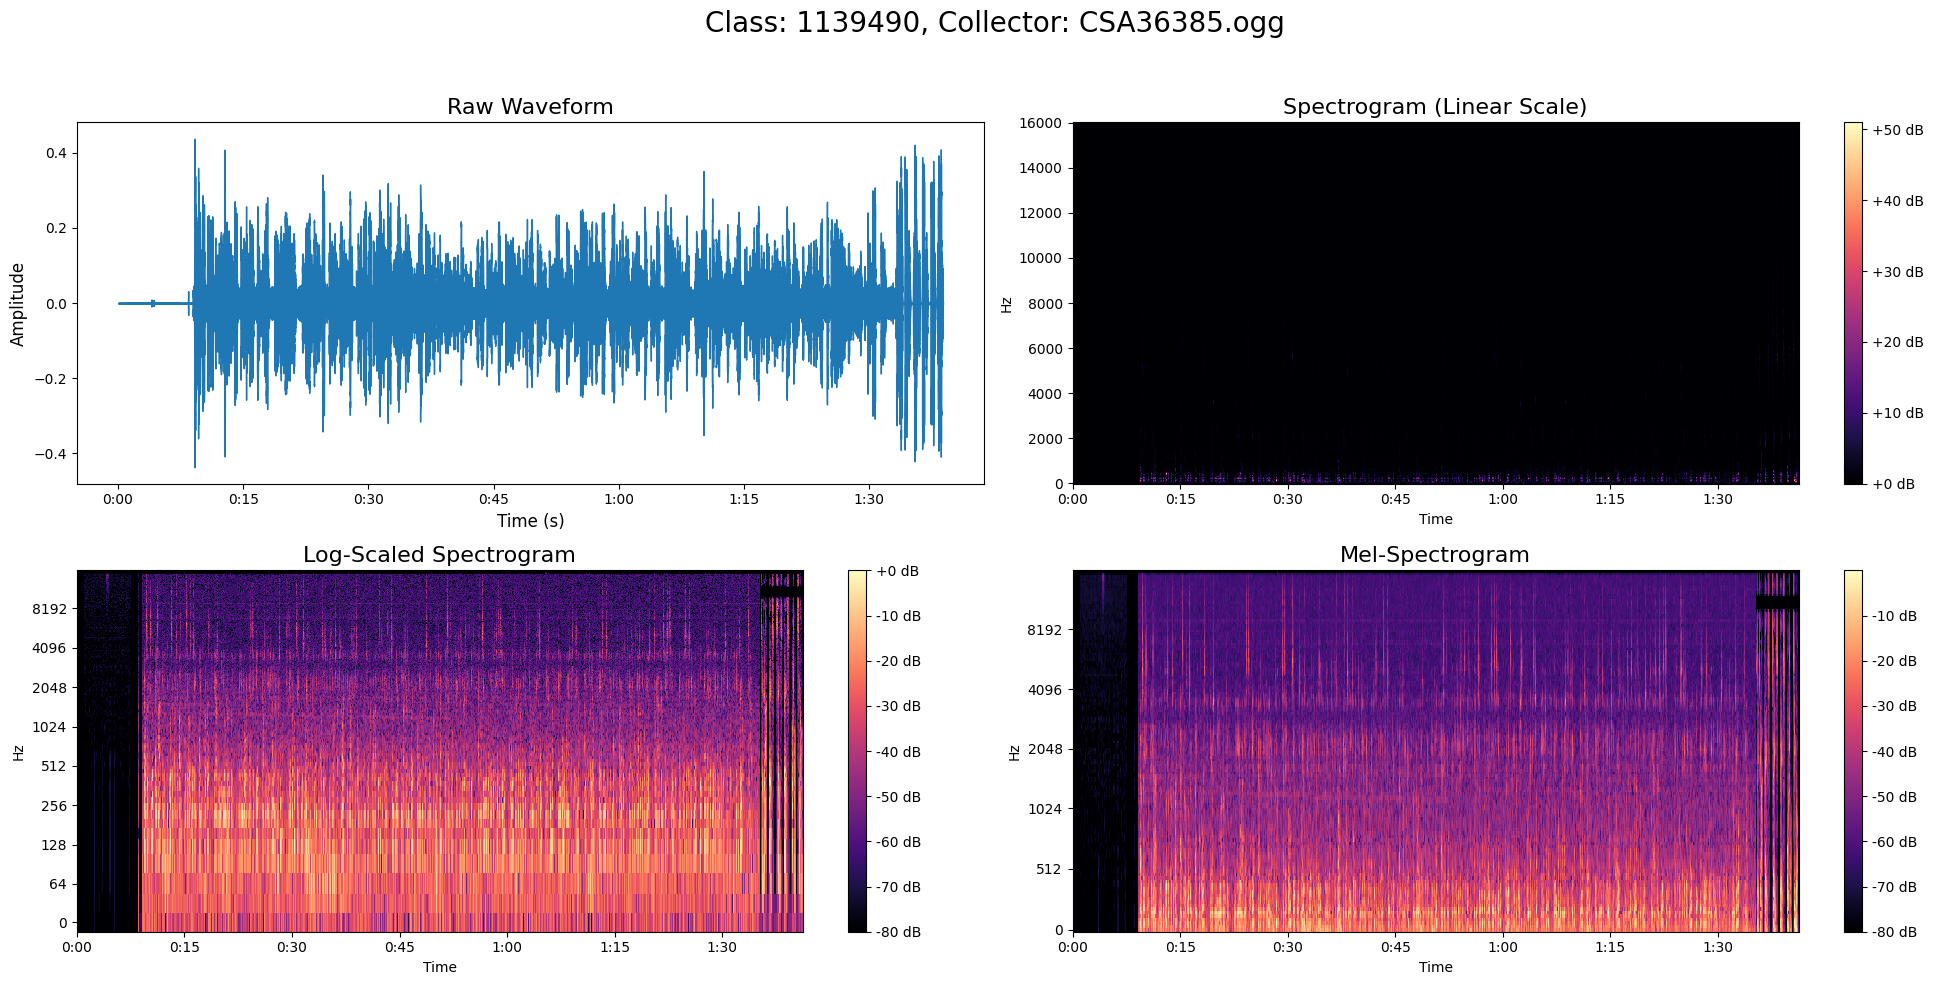

In [14]:
def show_signal(file_path):
    # Extract class and collector information from the file path (if applicable)
    class_, collector = file_path.split("/")[-2:] if "/" in file_path else ("Unknown", file_path.split("/")[-1])
    
    # Load the audio file
    y, sr = librosa.load(file_path, sr=Config.sr)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle(f"Class: {class_}, Collector: {collector}", fontsize=20)
    
    # Plotting Raw Waveform
    librosa.display.waveshow(y, sr=sr, ax=axes[0, 0])
    axes[0, 0].set_title("Raw Waveform", fontsize=16)
    axes[0, 0].set_xlabel("Time (s)", fontsize=12)
    axes[0, 0].set_ylabel("Amplitude", fontsize=12)
    
    # Plotting Spectrogram (Linear Scale)
    ft = np.abs(librosa.stft(y, n_fft=Config.n_fft, hop_length=Config.hop_length))
    im1 = librosa.display.specshow(ft, sr=sr, x_axis='time', y_axis='linear', ax=axes[0, 1], cmap='magma')
    axes[0, 1].set_title("Spectrogram (Linear Scale)", fontsize=16)
    fig.colorbar(im1, ax=axes[0, 1], format='%+2.0f dB')
    
    # Plotting Log-Scaled Spectrogram
    ft_db = librosa.amplitude_to_db(ft, ref=np.max)
    im2 = librosa.display.specshow(ft_db, sr=sr, x_axis='time', y_axis='log', ax=axes[1, 0], cmap='magma')
    axes[1, 0].set_title("Log-Scaled Spectrogram", fontsize=16)
    fig.colorbar(im2, ax=axes[1, 0], format='%+2.0f dB')
    
    # Plotting Mel-Spectrogram
    mel_sp = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=Config.n_fft, hop_length=Config.hop_length, 
                                            n_mels=Config.n_mels, fmin=Config.fmin, fmax=Config.fmax, power=Config.power)
    mel_sp_db = librosa.power_to_db(mel_sp, ref=np.max)
    im3 = librosa.display.specshow(mel_sp_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[1, 1], cmap='magma')
    axes[1, 1].set_title("Mel-Spectrogram", fontsize=16)
    fig.colorbar(im3, ax=axes[1, 1], format='%+2.0f dB')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

# Example: Call the function with a valid file path
show_signal(data_df['filename'].iloc[0])

In [15]:
# for idx, row in data_df.sample(10).iterrows(): show_signal(row['filename'])

# Data Preprocessing

In [16]:
# pip install birdnet or pip install birdnetlib

In [7]:
# import os
# import shutil
# import librosa
# import soundfile as sf
# import pandas as pd
# from pathlib import Path
# from birdnet import predict_species_within_audio_file, SpeciesPredictions
# from concurrent.futures import ProcessPoolExecutor, as_completed

# # ── CONFIG ──────────────────────────────────────────────
# class CFG:
#     raw_dir = r"C:\Users\Vineet\Desktop\Case Study Data Mining\birdclef-2025\train_audio"
#     bird_dir = r"C:\Users\Vineet\Desktop\Case Study Data Mining\birdclef-2025\train_audio_bird"
#     taxonomy_path = r"C:\Users\Vineet\Desktop\Case Study Data Mining\birdclef-2025\taxonomy.csv"
#     birdnet_threshold = 0.3
#     sample_rate = 32000
#     rms_thresh = 0.01
#     silent_pct = 0.5
#     min_duration = 1.0
#     max_duration = 10.0
#     num_workers = os.cpu_count() or 4  # Use all cores

# # ── LOAD ALLOWED SPECIES ────────────────────────────────
# taxonomy_df = pd.read_csv(CFG.taxonomy_path)
# valid_species_set = set(
#     taxonomy_df["scientific_name"] + "_" + taxonomy_df["common_name"]
# )

# # ── PROCESSING FUNCTION ─────────────────────────────────
# def process_file(src_path):
#     try:
#         # Duration check
#         try:
#             info = sf.info(src_path)
#             if not (CFG.min_duration <= info.duration <= CFG.max_duration):
#                 return "skipped_duration"
#         except Exception:
#             return "skipped_duration"

#         # Silence check
#         try:
#             y, _ = librosa.load(src_path, sr=CFG.sample_rate)
#             rms = librosa.feature.rms(y=y)[0]
#             if (rms < CFG.rms_thresh).mean() > CFG.silent_pct:
#                 return "skipped_silent"
#         except Exception:
#             return "skipped_silent"

#         # BirdNET check
#         try:
#             raw_preds = predict_species_within_audio_file(Path(src_path))
#             preds = SpeciesPredictions(raw_preds)

#             species_conf_pairs = [
#                 (species, conf)
#                 for interval in preds.values()
#                 for species, conf in interval.items()
#             ]
#             if not species_conf_pairs:
#                 return "skipped_birdnet"

#             for species, conf in species_conf_pairs:
#                 if species in valid_species_set and conf >= CFG.birdnet_threshold:
#                     # Passed all checks → copy file
#                     rel_path = os.path.relpath(src_path, CFG.raw_dir)
#                     dst_path = os.path.join(CFG.bird_dir, rel_path)
#                     os.makedirs(os.path.dirname(dst_path), exist_ok=True)
#                     shutil.copy(src_path, dst_path)
#                     return "kept"
#             return "skipped_birdnet"

#         except Exception:
#             return "skipped_birdnet"

#     except Exception as e:
#         print(f"[ERROR] Failed on {src_path}: {e}")
#         return "error"

# # ── GATHER ALL FILES ─────────────────────────────────────
# all_audio = [
#     os.path.join(root, fn)
#     for root, _, files in os.walk(CFG.raw_dir)
#     for fn in files
#     if fn.lower().endswith((".wav", ".ogg"))
# ]

# print(f"🔍 Scanning {len(all_audio)} files with {CFG.num_workers} workers...")

# # ── PARALLEL EXECUTION ───────────────────────────────────
# stats = {
#     "kept": 0,
#     "skipped_silent": 0,
#     "skipped_duration": 0,
#     "skipped_birdnet": 0,
#     "error": 0
# }

# with ProcessPoolExecutor(max_workers=CFG.num_workers) as executor:
#     futures = {executor.submit(process_file, f): f for f in all_audio}
#     for i, future in enumerate(as_completed(futures), 1):
#         result = future.result()
#         stats[result] += 1
#         if i % 100 == 0:
#             print(f"→ Processed {i}/{len(all_audio)}")

# # ── FINAL SUMMARY ────────────────────────────────────────
# print("\n✅ Filtering complete.")
# print(f"Total audio files scanned:        {len(all_audio)}")
# print(f"Files kept (valid bird clips):    {stats['kept']}")
# print(f"Skipped due to silence:           {stats['skipped_silent']}")
# print(f"Skipped due to duration:          {stats['skipped_duration']}")
# print(f"Skipped due to BirdNET mismatch:  {stats['skipped_birdnet']}")
# print(f"Errors or failures:               {stats['error']}")
# print(f"\nFiltered audio saved to: {CFG.bird_dir}")


In [14]:
# import os
# import numpy as np
# import soundfile as sf
# import tensorflow_hub as hub
# import tensorflow as tf
# import time
# import shutil

# class Config:
#     train_dir = "C:\\Users\\Vineet\\Desktop\\Case Study Data Mining\\birdclef-2025\\train_audio"
#     bird_dir  = "C:\\Users\\Vineet\\Desktop\\Case Study Data Mining\\birdclef-2025\\train_audio_bird"
#     seed = 42
#     train_csv = "C:\\Users\\Vineet\\Desktop\\Case Study Data Mining\\birdclef-2025\\train.csv"
#     sample_csv = "C:\\Users\\Vineet\\Desktop\\Case Study Data Mining\\birdclef-2025\\sample_submission.csv"
#     test_soundscapes = "C:\\Users\\Vineet\\Desktop\\Case Study Data Mining\\birdclef-2025\\test_soundscapes"
#     birdnet_threshold = 0.2  # Lowered threshold to reduce false negatives
#     sr = int(32e3)  # Sample rate
#     num_classes = 206  # Number of classes
#     n_fft = 1024  # fft points (samples)
#     hop_length = 500  # hop length (samples)
#     n_mels = 128  # number of mel bands
#     fmin = 50  # minimum frequency (Hz)
#     fmax = 16000  # maximum frequency (Hz)
#     power = 2  # power for mel-spectrogram
#     rms_thresh = 0.01  # below this = too quiet
#     silent_pct = 0.5  
#     sample_rate = 32000

# config = Config()

# # Load the Google Bird Vocalization Classifier
# model = hub.load('https://tfhub.dev/google/bird-vocalization-classifier/1')

# # Ensure the output directory exists
# os.makedirs(config.bird_dir, exist_ok=True)

# def has_bird_vocalization(audio_path):
#     """
#     Check if the audio file contains bird vocalizations by analyzing overlapping segments.
    
#     Args:
#         audio_path (str): Path to the audio file.
    
#     Returns:
#         bool: True if a bird is detected, False otherwise.
#     """
#     try:
#         # Load audio
#         audio, sr = sf.read(audio_path)
#         if sr != config.sample_rate:
#             print(f"Warning: {audio_path} has sample rate {sr}, expected {config.sample_rate}.")
#             return False
        
#         # Ensure audio is mono
#         if len(audio.shape) > 1:
#             audio = np.mean(audio, axis=1)
        
#         # Process in 5-second windows with overlap
#         window_size = 5 * config.sample_rate  # 5 seconds at 32kHz
#         step_size = window_size // 2  # 50% overlap
#         num_samples = len(audio)
        
#         for start in range(0, num_samples, step_size):
#             end = min(start + window_size, num_samples)
#             segment = audio[start:end]
            
#             # Check RMS threshold
#             rms = np.sqrt(np.mean(segment**2))
#             if rms < config.rms_thresh:
#                 continue
            
#             # Pad or truncate segment to exactly 5 seconds for model input
#             segment = segment.astype(np.float32)
#             if len(segment) < window_size:
#                 segment = np.pad(segment, (0, window_size - len(segment)), mode='constant')
#             elif len(segment) > window_size:
#                 segment = segment[:window_size]
            
#             # Run model inference
#             logits, _ = model.infer_tf(segment[np.newaxis, :])
#             max_confidence = tf.reduce_max(tf.nn.sigmoid(logits)).numpy()
            
#             if max_confidence >= config.birdnet_threshold:
#                 return True
        
#         return False
    
#     except Exception as e:
#         print(f"Error processing {audio_path}: {e}")
#         return False

# def main():
#     """Traverse the train_audio directory, filter files with bird vocalizations, and copy to bird_dir."""
#     start_time = time.time()
#     file_count = 0
#     bird_files = 0
    
#     for root, _, files in os.walk(config.train_dir):
#         for file in files:
#             if file.endswith('.ogg'):
#                 audio_path = os.path.join(root, file)
#                 file_count += 1
#                 if has_bird_vocalization(audio_path):
#                     # Copy original file to bird_dir preserving subfolder structure
#                     relative_path = os.path.relpath(audio_path, config.train_dir)
#                     dest_path = os.path.join(config.bird_dir, relative_path)
#                     os.makedirs(os.path.dirname(dest_path), exist_ok=True)
#                     shutil.copy2(audio_path, dest_path)
#                     bird_files += 1
    
#     end_time = time.time()
#     total_time = end_time - start_time
#     avg_time_per_file = total_time / file_count if file_count > 0 else 0
    
#     print(f"Total processing time: {total_time:.2f} seconds")
#     print(f"Number of files processed: {file_count}")
#     print(f"Number of files with birds: {bird_files}")
#     print(f"Average time per file: {avg_time_per_file:.2f} seconds")

# if __name__ == "__main__":
#     main()

In [ ]:
import os
import numpy as np
import soundfile as sf
import tensorflow_hub as hub
import tensorflow as tf
import time
import shutil

class Config:
    train_dir = r"C:\Users\Vineet\Desktop\Case Study Data Mining\birdclef-2025\train_audio"
    bird_dir  = r"C:\Users\Vineet\Desktop\Case Study Data Mining\birdclef-2025\train_audio_bird"
    sample_rate = 32000
    threshold = 0.2
    rms_thresh = 0.01
    window_sec = 5
    stride_sec = 2.5   # 50% overlap
    min_audio_len = 1  # in seconds

config = Config()

# Load the Google Bird Vocalization Classifier
model = hub.load('https://tfhub.dev/google/bird-vocalization-classifier/1')

# Ensure output directory exists
os.makedirs(config.bird_dir, exist_ok=True)

def has_bird_vocalization(audio_path):
    try:
        # Load and validate audio
        audio, sr = sf.read(audio_path)
        if sr != config.sample_rate:
            return False
        if len(audio.shape) > 1:
            audio = np.mean(audio, axis=1)  # stereo to mono

        if len(audio) < config.min_audio_len * config.sample_rate:
            return False

        # Prepare windowing
        window_size = int(config.window_sec * config.sample_rate)
        stride_size = int(config.stride_sec * config.sample_rate)
        num_samples = len(audio)

        for start in range(0, num_samples - window_size + 1, stride_size):
            segment = audio[start:start + window_size]
            
            # Basic silence filter
            if np.sqrt(np.mean(segment**2)) < config.rms_thresh:
                continue

            segment = segment.astype(np.float32)
            logits, _ = model.infer_tf(segment[np.newaxis, :])
            max_confidence = tf.reduce_max(tf.nn.sigmoid(logits)).numpy()

            if max_confidence >= config.threshold:
                return True

        return False

    except Exception as e:
        print(f"[ERROR] Failed on {audio_path}: {e}")
        return False

def main():
    start_time = time.time()
    total_files = 0
    bird_files = 0

    for root, _, files in os.walk(config.train_dir):
        for file in files:
            if not file.endswith('.ogg'):
                continue

            total_files += 1
            audio_path = os.path.join(root, file)

            if has_bird_vocalization(audio_path):
                # Copy with folder structure preserved
                relative_path = os.path.relpath(audio_path, config.train_dir)
                dest_path = os.path.join(config.bird_dir, relative_path)
                os.makedirs(os.path.dirname(dest_path), exist_ok=True)
                shutil.copy2(audio_path, dest_path)
                bird_files += 1

            if total_files % 100 == 0:
                print(f"Scanned {total_files} files...")

    elapsed = time.time() - start_time
    print("\n✅ Filtering complete.")
    print(f"Total files processed:  {total_files}")
    print(f"Files with birds kept:  {bird_files}")
    print(f"Total time:             {elapsed:.2f}s")
    print(f"Avg time per file:      {elapsed / total_files:.2f}s")

if __name__ == "__main__":
    main()


Scanned 100 files...
Scanned 200 files...
Scanned 300 files...
Scanned 400 files...
Scanned 500 files...
Scanned 600 files...
Scanned 700 files...
Scanned 800 files...
Scanned 900 files...
Scanned 1000 files...
Scanned 1100 files...
Scanned 1200 files...
Scanned 1300 files...
Scanned 1400 files...
Scanned 1500 files...
Scanned 1600 files...
Scanned 1700 files...
Scanned 1800 files...
Scanned 1900 files...
Scanned 2000 files...
Scanned 2100 files...
Scanned 2200 files...
Scanned 2300 files...
Scanned 2400 files...
Scanned 2500 files...
Scanned 2600 files...
Scanned 2700 files...
Scanned 2800 files...
Scanned 2900 files...
Scanned 3000 files...
Scanned 3100 files...
Scanned 3200 files...
Scanned 3300 files...
Scanned 3400 files...
Scanned 3500 files...
Scanned 3600 files...
Scanned 3700 files...
Scanned 3800 files...
Scanned 3900 files...
Scanned 4000 files...
Scanned 4100 files...
Scanned 4200 files...
Scanned 4300 files...
Scanned 4400 files...
Scanned 4500 files...
Scanned 4600 files.

# Noise Remove, Bandpass Filtering and Normalization

#### Problem - selects highest RMS segment, however bird sometime has low RMS, alternative use Top-N RMS segments 

In [ ]:
# # === Setup logging ===
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# # === Bandpass Filter ===
# def bandpass_filter(y, sr, lowcut=Config.lowcut, highcut=Config.highcut, order=Config.order):
#     sos = butter(order, [lowcut, highcut], btype='band', fs=sr, output='sos')
#     return sosfilt(sos, y)

# # === Normalize amplitude ===
# def normalize_audio(y):
#     max_amplitude = np.max(np.abs(y))
#     if max_amplitude > 0:
#         return y / (max_amplitude + 1e-8)
#     logging.warning("Audio has zero amplitude, returning unchanged")
#     return y

# # === Cyclic padding ===
# def apply_cyclic_padding(y, target_len=Config.target_length):
#     if len(y) >= target_len:
#         return y[:target_len]
#     else:
#         repeat_count = int(np.ceil(target_len / len(y)))
#         y_extended = np.tile(y, repeat_count)
#         return y_extended[:target_len]

# def extract_best_window(y, sr, window_size_sec=5, stride_sec=1):
#     window_size = int(window_size_sec * sr)
#     stride = int(stride_sec * sr)

#     best_rms = 0
#     best_start = 0
#     for start in range(0, len(y) - window_size + 1, stride):
#         window = y[start:start + window_size]
#         rms = np.sqrt(np.mean(window**2))
#         if rms > best_rms:
#             best_rms = rms
#             best_start = start

#     return y[best_start:best_start + window_size]


# def preprocess_audio(file_path, output_path):
#     if not os.path.exists(file_path):
#         logging.error(f"File not found: {file_path}")
#         return

#     try:
#         y, sr = librosa.load(file_path, sr=Config.sr_target, mono=True)
#         logging.info(f"Loaded: {file_path} | Length: {len(y)} | Sample rate: {sr}")

#         if len(y) < Config.target_length:
#             logging.warning(f"Too short, applying cyclic padding")
#             y = apply_cyclic_padding(y, Config.target_length)
#         else:
#             # Get loudest 5s window
#             y = extract_best_window(y, sr, window_size_sec=5, stride_sec=1)

#         # Optional: skip too silent segments
#         rms = np.sqrt(np.mean(y**2))
#         if rms < Config.rms_thresh:
#             logging.warning(f"Low RMS after selection (RMS={rms:.5f}), skipping: {file_path}")
#             return

#         # Post-processing: filter, normalize
#         y = bandpass_filter(y, sr)
#         y = normalize_audio(y)
#         # Optionally apply light noise reduction AFTER selection
#         y = nr.reduce_noise(y=y, sr=sr, prop_decrease=0.75)

#         os.makedirs(os.path.dirname(output_path), exist_ok=True)
#         sf.write(output_path, y, sr)
#         logging.info(f"Saved: {output_path}")

#     except Exception as e:
#         logging.error(f"Error processing {file_path}: {e}")


# # === Batch processor ===
# def batch_preprocess(input_dir=Config.train_bird_dir, output_dir=Config.processed_audio_dir):
#     total = 0
#     processed = 0

#     for root, _, files in os.walk(input_dir):
#         for file in tqdm(files, desc="Preprocessing"):
#             ext = os.path.splitext(file)[-1].lower()
#             if ext not in [".wav", ".ogg"]:
#                 continue

#             total += 1
#             input_path = os.path.join(root, file)
#             rel_path = os.path.relpath(input_path, input_dir)
#             rel_path = os.path.splitext(rel_path)[0] + ".ogg"  # save all as .wav
#             output_path = os.path.join(Config.processed_audio_dir, rel_path)

#             preprocess_audio(input_path, output_path)
#             if os.path.exists(Config.processed_audio_dir):
#                 processed += 1

#     logging.info(f"Finished. Processed {processed}/{total} audio files.")

# # === Run ===
# if __name__ == "__main__":
#     batch_preprocess()


In [1]:
import os
import librosa
import soundfile as sf
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
from tqdm import tqdm
import logging

# === Logging setup ===
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# === Configuration ===
class Config:
    input_dir = "C:\\Users\\Vineet\\Desktop\\Case Study Data Mining\\birdclef-2025\\train_audio_bird"
    output_dir = "C:\\Users\\Vineet\\Desktop\\Case Study Data Mining\\birdclef-2025\\processed_audio"
    sr = 32000
    segment_sec = 5
    stride_sec = 2.5  # 50% overlap
    target_length = sr * segment_sec
    threshold = 0.3  # Confidence threshold to save weakly labeled segments

# === Utility functions ===
def normalize_audio(y):
    max_amp = np.max(np.abs(y))
    return y / (max_amp + 1e-8) if max_amp > 0 else y

def apply_cyclic_padding(y, target_len=Config.target_length):
    if len(y) >= target_len:
        return y[:target_len]
    return np.tile(y, int(np.ceil(target_len / len(y))))[:target_len]

# === Load GBVC TensorFlow Hub model ===
logging.info("Loading GBVC model from TensorFlow Hub...")
model = hub.load("https://tfhub.dev/google/bird-vocalization-classifier/1")  
inference_fn = model.signatures["serving_default"]

# === Process a single audio file ===
def process_file(file_path, output_base_dir, rel_path):
    try:
        audio, _ = librosa.load(file_path, sr=Config.sr, mono=True)
        audio = normalize_audio(audio)

        rel_species_folder = os.path.dirname(rel_path)
        base_name = os.path.splitext(os.path.basename(file_path))[0]

        stride_samples = int(Config.sr * Config.stride_sec)
        for i, start in enumerate(range(0, len(audio) - Config.target_length + 1, stride_samples)):
            segment = audio[start:start + Config.target_length]
            if len(segment) < Config.target_length:
                segment = apply_cyclic_padding(segment)

            input_tensor = tf.convert_to_tensor(segment[np.newaxis, :], dtype=tf.float32)
            result = inference_fn(inputs=input_tensor)

            # Get prediction
            probs = result["output_0"].numpy()[0]  # shape: (10932,)
            class_names = result["classes"].numpy()
            top_idx = np.argmax(probs)
            top_score = probs[top_idx]
            top_label = class_names[top_idx].decode("utf-8")

            if top_score < Config.threshold:
                continue  # Skip low confidence segments

            out_name = f"{base_name}_{i}_{top_label}_{top_score:.2f}.wav"
            out_dir = os.path.join(output_base_dir, rel_species_folder)
            os.makedirs(out_dir, exist_ok=True)

            out_path = os.path.join(out_dir, out_name)
            sf.write(out_path, segment, Config.sr)
            logging.info(f"Saved: {out_path}")

    except Exception as e:
        logging.error(f"Error processing {file_path}: {e}")

# === Batch processing all files in directory ===
def batch_process(input_dir=Config.input_dir, output_dir=Config.output_dir):
    for root, _, files in os.walk(input_dir):
        for file in tqdm(files, desc="GBVC-TF Preprocessing"):
            ext = os.path.splitext(file)[-1].lower()
            if ext not in [".ogg", ".wav", ".mp3"]:
                continue

            input_path = os.path.join(root, file)
            rel_path = os.path.relpath(input_path, input_dir)
            process_file(input_path, output_dir, rel_path)

# === Run the script ===
if __name__ == "__main__":
    batch_process()


KeyboardInterrupt: 

# Saving Audio to Images 

KeyboardInterrupt: 

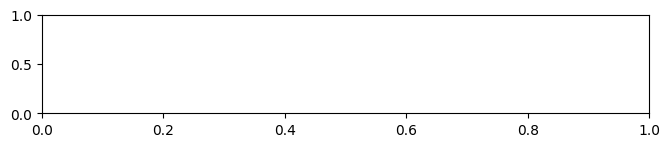

In [ ]:
def save_mel_spectrogram(
    filepath,
    out_dir,
    image_size=(224, 224),
    sr=Config.sr,
    n_fft=Config.n_fft,
    hop_length=Config.hop_length,
    n_mels=Config.n_mels,
    fmin=Config.fmin,
    fmax=Config.fmax,
    power=Config.power,
):
    """Load an audio file → mel-spectrogram → resize → save as 224×224 PNG."""
    # 1) Load & get mel-spectrogram in dB
    y, _ = librosa.load(filepath, sr=sr)
    mel_sp = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        fmin=fmin,
        fmax=fmax,
        power=power,
    )
    mel_db = librosa.power_to_db(mel_sp, ref=np.max)

    # 2) Plot to an in-memory buffer
    fig = plt.figure(figsize=(mel_db.shape[1]/100, mel_db.shape[0]/100), dpi=100)
    librosa.display.specshow(
        mel_db, 
        sr=sr, 
        hop_length=hop_length, 
        x_axis=None, 
        y_axis=None, 
        cmap='magma'
    )
    plt.axis('off')
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)

    # 3) Open with PIL, resize to 224×224, and save
    img = Image.open(buf)
    img = img.resize(image_size, resample=Image.BILINEAR)

    fname = os.path.splitext(os.path.basename(filepath))[0] + '.png'
    out_path = os.path.join(out_dir, fname)
    os.makedirs(out_dir, exist_ok=True)
    img.save(out_path)

    return out_path

# Example batch run:
audio_dir   = Config.train_dir
img_out_dir = os.path.join('mel_images', 'train_224')

for root, _, files in os.walk(audio_dir):
    for fname in files:
        if fname.lower().endswith('.ogg'):
            in_path = os.path.join(root, fname)
            save_mel_spectrogram(in_path, img_out_dir)
